## Andrej's makemore lecture - 3

Implementation following Andrej Karpathy's lecture [Building makemore Part 3: Activations & Gradients, BatchNorm](https://youtu.be/P6sfmUTpUmc).

I have some liberty to refactor and pythonise his implementation.

In [2]:
import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    target_version=black.TargetVersion.PY310,
)

<IPython.core.display.Javascript object>

In [24]:
import torch

# import torch.overrides


# _DEVICE_CONSTRUCTOR = {
#     # standard ones
#     torch.empty,
#     torch.empty_strided,
#     torch.empty_quantized,
#     torch.ones,
#     torch.arange,
#     torch.bartlett_window,
#     torch.blackman_window,
#     torch.eye,
#     torch.fft.fftfreq,
#     torch.fft.rfftfreq,
#     torch.full,
#     torch.fill,
#     torch.hamming_window,
#     torch.hann_window,
#     torch.kaiser_window,
#     torch.linspace,
#     torch.logspace,
#     # torch.nested_tensor,
#     # torch.normal,
#     torch.ones,
#     torch.rand,
#     torch.randn,
#     torch.randint,
#     torch.randperm,
#     torch.range,
#     torch.sparse_coo_tensor,
#     torch.sparse_compressed_tensor,
#     torch.sparse_csr_tensor,
#     torch.sparse_csc_tensor,
#     torch.sparse_bsr_tensor,
#     torch.sparse_bsc_tensor,
#     torch.tril_indices,
#     torch.triu_indices,
#     torch.vander,
#     torch.zeros,
#     torch.asarray,
#     # weird ones
#     torch.tensor,
#     torch.as_tensor,
# }


# class DeviceMode(torch.overrides.TorchFunctionMode):
#     def __init__(self, device):
#         super().__init__()
#         self.device = torch.device(device)

#     def __torch_function__(self, func, types, args=(), kwargs=None):
#         if kwargs is None:
#             kwargs = {}
#         if func in _DEVICE_CONSTRUCTOR:
#             if kwargs.get("device") is None:
#                 kwargs["device"] = self.device
#             return func(*args, **kwargs)
#         return func(*args, **kwargs)


# if torch.backends.mps.is_available():
#     DEVICE_TYPE = "cpu"
#     DeviceMode.push(torch.device(DEVICE_TYPE)).__enter__()
# else:
#     DEVICE_TYPE = "cpu"
#     print("MPS device not found.")

In [4]:
from IPython.display import display, HTML, clear_output

display(HTML("<style>.container { width:100% !important; }</style>"))


from dataclasses import dataclass, field
import typing as t
import itertools as it
import collections as c
import json
from copy import deepcopy
import math
import time
import functools as ft
import numpy as np
import random
from tqdm.notebook import tqdm
import heapq
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.size"] = 14

import torch.nn.functional as F
import torch as T
import torch.utils.tensorboard as tb

In [5]:
# Number of past tokens to use to predict next token
CTX_WIN_SZ = 8

### Load data

In [6]:
DOT = "."
words = open("names.txt").read().splitlines()
words[:4]

['emma', 'olivia', 'ava', 'isabella']

#### Build mapping of character to index

In [7]:
def build_ixes(words):
    chars = [DOT] + sorted(set(it.chain.from_iterable(words)))
    ctoix = {c: i for i, c in enumerate(chars)}
    ixtoc = dict(enumerate(chars))
    return (ctoix, ixtoc)

In [8]:
(ctoix, ixtoc) = build_ixes(words)

#### Create training data with context window size

In [9]:
def build_train_data(words, ctoix, ctx_win=CTX_WIN_SZ):
    Xs, Ys = [], []
    pad = DOT * ctx_win
    for wnum, w in enumerate(words):
        pw = pad + w + DOT
        if wnum < 2:
            print(pw)
        for i in range(len(w) + 1):
            if wnum < 2:
                print(pw[i : i + ctx_win], "--->", pw[i + ctx_win])
            Xs.append([ctoix[c] for c in pw[i : i + ctx_win]])
            Ys.append([ctoix[pw[i + ctx_win]]])
    return T.tensor(Xs, dtype=int), T.tensor(Ys, dtype=int).flatten()

In [10]:
Xs, Ys = build_train_data(words, ctoix, ctx_win=CTX_WIN_SZ)
n, m = Xs.shape
n, m

........emma.
........ ---> e
.......e ---> m
......em ---> m
.....emm ---> a
....emma ---> .
........olivia.
........ ---> o
.......o ---> l
......ol ---> i
.....oli ---> v
....oliv ---> i
...olivi ---> a
..olivia ---> .


(228146, 8)

In [11]:
Ys[:30]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9])

#### Train, validation, test split

In [12]:
VOCAB_SIZE = len(ctoix)
VOCAB_SIZE

27

In [13]:
ntrain, nval = int(n * 0.8), int(n * 0.1)
ntest = n - ntrain - nval
print(f"{ntrain=}, {nval=}, {ntest=}")
ixes = list(range(0, n))
random.shuffle(ixes)
valend = ntrain + nval
ixtr, ixval, ixtest = ixes[:ntrain], ixes[ntrain:valend], ixes[valend:]

ntrain=182516, nval=22814, ntest=22816


In [14]:
(Xtr, Ytr), (Xval, Yval) = (Xs[ixtr], Ys[ixtr]), (Xs[ixval], Ys[ixval])
(Xtest, Ytest) = (Xs[ixtest], Ys[ixtest])

In [15]:
Xtest, Ytest

(tensor([[ 0,  0,  0,  ...,  0,  1, 21],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  4,  5, 12],
         [ 0,  0,  0,  ...,  0,  0, 11]]),
 tensor([ 7, 10, 10,  ...,  8, 25, 15]))

In [16]:
print(Xtr.shape, Xval.shape, Xtest.shape)

torch.Size([182516, 8]) torch.Size([22814, 8]) torch.Size([22816, 8])


### Model layer implementations

Requires building following layers

- Embedding
- Linear layer
- BatchNorm1D
- Tanh

In [17]:
########################################################################
#  Embedding
########################################################################
@dataclass
class Embedding:

    num_embed: int
    embed_dim: int
    flatten: bool = True
    E: T.Tensor = field(init=False, repr=False)
    _params: list[T.Tensor] = field(init=False, repr=False)
    #: last forward pass, mutated during forward pass
    out: t.Optional[T.Tensor] = field(default=None, repr=False)

    def __post_init__(self):
        self.E = T.randn(self.num_embed, self.embed_dim)
        self._params = [self.E]
        self.parameters = lambda: self._params

    def __call__(self, X, inference=False):
        batch_sz, num_tkns = X.shape
        if self.flatten:
            self.out = self.E[X].view(batch_sz, -1)
        else:
            self.out = self.E[X]
        return self.out


########################################################################
#  Flatten
########################################################################
@dataclass
class FlattenConsecutive:

    #: number of input ctx word embeds to concat
    n: int
    #: last forward pass, mutated during forward pass
    out: t.Optional[T.Tensor] = field(default=None, repr=False)
    parameters = lambda self: []

    def __call__(self, X, inference=False):
        B, T, C = X.shape
        X_flat = X.view(B, T // self.n, C * self.n)
        if X_flat.shape[1] != 1:
            self.out = X_flat
        else:
            # we want to concatenate all characters
            self.out = X_flat.squeeze(dim=1)
        return self.out


########################################################################
#  Linear
########################################################################
@dataclass
class Linear:

    fanin: int
    fanout: int
    bias: bool = True
    # gain used in kaiming he activation
    wt_gain: float = 1.0
    # if not set we use kaiming he activation
    init_wt_scale: t.Optional[float] = None
    b: t.Optional[T.Tensor] = field(init=False, repr=False)
    W: T.Tensor = field(init=False, repr=False)
    _params: list[T.Tensor] = field(init=False, repr=False)
    #: last forward pass, mutated during forward pass
    out: t.Optional[T.Tensor] = field(default=None, repr=False)

    def __post_init__(self):
        if self.init_wt_scale is None:
            self.init_wt_scale = self.wt_gain / (self.fanin**0.5)
        # sample from uniform random
        self.W = T.empty(self.fanin, self.fanout).uniform_(
            -self.init_wt_scale, self.init_wt_scale
        )
        if self.bias:
            self.b = T.ones(1, self.fanout) * 0.01
            self._params = [self.W, self.b]
        else:
            self.b = None
            self._params = [self.W]
        self.parameters = lambda: self._params

    def __call__(self, X, inference=False):
        if self.bias:
            self.out = X @ self.W + self.b
        else:
            self.out = X @ self.W
        return self.out


########################################################################
#  BatchNorm1D
########################################################################
@dataclass
class BatchNorm1D:

    size: int
    ndim: int
    momentum: float = 0.01
    eps: float = 1e-5
    #: scaling after standardising
    gamma: T.Tensor = field(init=False, repr=False)
    #: shift after standardising
    beta: T.Tensor = field(init=False, repr=False)
    _params: list[T.Tensor] = field(init=False, repr=False)
    #: running averages of mean and variance
    buffer_mean: T.Tensor = field(init=False, repr=False)
    buffer_var: T.Tensor = field(init=False, repr=False)
    #: last forward pass, mutated during forward pass
    out: t.Optional[T.Tensor] = field(default=None, repr=False)

    def __post_init__(self):
        _pdims = [1] * (self.ndim - 1) + [self.size]
        self.gamma = T.ones(*_pdims)
        self.beta = T.zeros(*_pdims)
        self._params = [self.gamma, self.beta]
        self.parameters = lambda: self._params
        self.buffer_mean = T.zeros(*_pdims, requires_grad=False)
        self.buffer_var = T.ones(*_pdims, requires_grad=False)

    def __call__(self, X, inference=False):
        fwd_fn = self._fwd_inference if inference else self._fwd_train
        return fwd_fn(X)

    def _fwd_train(self, X):
        if self.ndim == 2:
            agg_dims = 0
        elif self.ndim == 3:
            agg_dims = (0, 1)
        else:
            raise NotImplementedError(f"BNorm for {self.ndim=}")
        mu = X.mean(dim=agg_dims, keepdims=True)
        var = X.var(dim=agg_dims, keepdims=True) + self.eps
        with T.no_grad():
            mom_old, mom_new = 1 - self.momentum, self.momentum
            self.buffer_mean = mom_old * self.buffer_mean + mom_new * mu
            self.buffer_var = mom_old * self.buffer_var + mom_new * var
        self.out = BatchNorm1D._fwd(
            X=X, mu=mu, var=var, gamma=self.gamma, beta=self.beta
        )
        return self.out

    def _fwd_inference(self, X):
        with T.no_grad():
            self.out = BatchNorm1D._fwd(
                X=X,
                mu=self.buffer_mean,
                var=self.buffer_var,
                gamma=self.gamma,
                beta=self.beta,
            )
            return self.out

    @staticmethod
    def _fwd(X, mu, var, gamma, beta):
        X_std = (X - mu) / T.sqrt(var)
        return (X_std * gamma) + beta


########################################################################
#  Tanh
########################################################################
@dataclass
class Tanh:

    #: last forward pass, mutated during forward pass
    out: t.Optional[T.Tensor] = field(default=None, repr=False)

    def parameters(self):
        return []

    def __call__(self, X, inference=False):
        self.out = T.tanh(X)
        return self.out


########################################################################
#  Sequential
########################################################################
@dataclass
class Sequential:

    layers: list
    #: last forward pass, mutated during forward pass
    out: t.Optional[T.Tensor] = field(default=None, repr=False)

    def __post_init__(self):
        self._params = [p for lyr in self.layers for p in lyr.parameters()]
        self.parameters = lambda: self._params
        for p in self._params:
            p.requires_grad = True

    def __call__(self, X, inference=False):
        x = X
        for layer in self.layers:
            x = layer(x, inference=inference)
        self.out = x
        return self.out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}(\n\t"
            + "\n\t".join(
                f"{str(lyr)}\tout={None if lyr.out is None else tuple(lyr.out.shape)}"
                for lyr in self.layers
            )
            + "\n)"
        )

    def __getitem__(self, layer_num):
        return self.layers[layer_num]

### Training loop
- Split data into batches
- Fwd pass, zero grad, loss.backward, batch gradient update.
- Keep track of learning losses for later plotting.

In [30]:
def train_loop(
    Xs,
    Ys,
    mdl,
    lr,
    num_iter,
    batch_sz=128,
    losses=None,
    wt_update_ratios=None,
    plot_losses=True,
):
    # train_ix to loss
    wt_update_ratios = wt_update_ratios if wt_update_ratios is not None else {}
    losses = losses if losses is not None else []
    # Setup
    nrows = Xs.shape[0]
    itrs = tqdm(range(num_iter), leave=False)
    total_iter = len(losses)
    # Train loop
    for i in itrs:
        total_iter += 1
        batch_ix = torch.randint(0, nrows, (batch_sz,))
        p = mdl(X=Xs[batch_ix])
        loss = F.cross_entropy(input=p, target=Ys[batch_ix])
        losses.append(loss.item())
        # The output of each layer is an intermediate computation
        # the gradient is only needed for model params. We force
        # pytorch to keep these grads.
        retain_out_grad(mdl)
        _zero_grad(mdl=mdl)
        loss.backward()
        _update_params(
            mdl=mdl,
            lr=_get_lr(lr=lr, it=total_iter),
            wt_update_ratios=wt_update_ratios,
        )
        if i % 1000 == 0:
            itrs.set_description(f"Loss: {loss.item():.2f}")
    if plot_losses:
        _plot_losses(losses[:])
        split_loss(mdl=mdl, split="train")
        split_loss(mdl=mdl, split="val")
    return losses


def retain_out_grad(mdl):
    for layer in mdl.layers:
        layer.out.retain_grad()


def fwd_proba(Xs, mdl, inference):
    return F.softmax(mdl(X=Xs, inference=inference), dim=1)


def _get_lr(lr, it):
    if isinstance(lr, (int, float, T.TensorType, T.Tensor)):
        return lr
    elif isinstance(lr, dict):
        for (min_it, max_it), _lr in lr.items():
            if min_it <= _lr < max_it:
                return _lr
        else:
            raise ValueError(f"Iteration {it} not in any range in {lr}")
    else:
        raise NotImplementedError(
            f"Don't know how to handle learning {lr} of type {type(lr)}"
        )


def _zero_grad(mdl):
    for param in mdl.parameters():
        param.grad = None


def _update_params(mdl, lr, wt_update_ratios):
    lyr_num = 0
    for param in mdl.parameters():
        param.data -= lr * param.grad
        ########################################################################
        #  Collect update/weight ratios log10((lr * param.grad).std() / W.std())
        ########################################################################
        if param.ndim != 2 or param.shape[0] == 1:
            # only pick linear layer, don't choose gradients for batchnorm
            continue
        # weight updates only for W matrices
        lyr_num += 1
        wname = f"W_{lyr_num}"
        ratios = wt_update_ratios.get(wname, [])
        ratios.append(
            ((lr * param.grad).std() / param.data.std()).log10().item()
        )
        wt_update_ratios[wname] = ratios


def _loss(Xs, Ys, mdl):
    logits = mdl(X=Xs, inference=True)
    return F.cross_entropy(input=logits, target=Ys).item()


def _plot_losses(losses: list[int], win_avg=100):
    plt.figure(figsize=(10, 4))
    losses = torch.tensor(losses)
    # if not an exact multiple of window size truncate to the last exact multiple.
    binned_n = len(losses) // win_avg
    n = binned_n * win_avg
    losses2d = losses[:n].view(-1, win_avg)
    avg_losses = losses2d.mean(dim=1)
    std_losses = losses2d.std(dim=1)
    xs = torch.arange(binned_n, device="cpu") * win_avg
    plt.plot(xs, avg_losses)
    plt.fill_between(
        xs,
        avg_losses - std_losses,
        avg_losses + std_losses,
        color="gray",
        alpha=0.2,
    )
    plt.title("Loss vs iteration")
    plt.xlabel("Iter")
    plt.ylabel("Cross entropy or NLL loss")
    plt.grid()


@T.no_grad()
def generate_words(mdl, nwords, ctoix, ctx_win=CTX_WIN_SZ, generator=None):
    st_X = _ctx_to_X(ctx_chars=DOT * CTX_WIN_SZ, ctoix=ctoix).repeat(nwords, 1)
    lst_X = st_X
    words = [[] for _ in range(nwords)]
    for i in range(30):
        # print(f"{lst_X=}")
        new_X = T.multinomial(
            input=fwd_proba(Xs=lst_X, mdl=mdl, inference=True),
            num_samples=1,
            replacement=True,
            generator=generator,
        )
        # print(f"{new_X=}")
        char_added = False
        for w, ix in zip(words, new_X):
            if w and w[-1] == DOT:
                continue
            char_added |= True
            w.append(ixtoc[ix.item()])
        lst_X[:, :-1] = lst_X[:, 1:]
        lst_X[:, -1] = new_X.squeeze()
        # print(f"{lst_X=}\n\n")
        if not char_added:
            break
    return ["".join(w[:-1]) for w in words]


def num_params(mdl):
    return sum(T.numel(param) for param in mdl.parameters())


def _ctx_to_X(ctx_chars, ctoix):
    return T.tensor([ctoix[c] for c in ctx_chars]).unsqueeze(dim=0)

#### Train validation and test losses

In [19]:
@T.no_grad()
def _split_loss(Xtr, Ytr, Xval, Yval, Xtest, Ytest, mdl, split):
    match split:
        case "train":
            spl, loss = "Train", _loss(Xtr, Ytr, mdl)
        case "val":
            spl, loss = "Validation", _loss(Xval, Yval, mdl)
        case "test":
            spl, loss = "Test", _loss(Xtest, Ytest, mdl)
        case _:
            raise NotImplementedError("Split should be train, val or test")
    print(f"{spl} loss={loss:.4f}")
    return loss


split_loss = ft.partial(
    _split_loss,
    Xtr=Xtr,
    Ytr=Ytr,
    Xval=Xval,
    Yval=Yval,
    Xtest=Xtest,
    Ytest=Ytest,
)

### Build model by stacking Layers

In [20]:
EMBED_DIM = 10
HIDDEN_DIM = 68
NUM_HIDDEN = 1

In [21]:
def build_bengio_model(
    vocab_size=VOCAB_SIZE,
    ctx_win=CTX_WIN_SZ,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_hidden=NUM_HIDDEN,
    lin_wt_gain=1.0,
    init_wt_scale=None,
    batchnorm=False,
):
    assert hidden_dim > 0, "at least one hidden dim is needed"
    lkwrgs = dict(wt_gain=lin_wt_gain, init_wt_scale=init_wt_scale)
    if batchnorm:
        activation_fn = lambda: [BatchNorm1D(size=hidden_dim, ndim=2), Tanh()]
    else:
        activation_fn = lambda: [Tanh()]
    layers = [
        Embedding(num_embed=vocab_size, embed_dim=embed_dim, flatten=False),
        FlattenConsecutive(n=ctx_win),
        Linear(fanin=embed_dim * ctx_win, fanout=hidden_dim, **lkwrgs),
    ] + activation_fn()
    for _ in range(num_hidden - 1):
        layers.extend([Linear(fanin=hidden_dim, fanout=hidden_dim, **lkwrgs)])
        layers.extend(activation_fn())
    if batchnorm:
        layers.append(Linear(fanin=hidden_dim, fanout=vocab_size, wt_gain=1.0))
        bn = BatchNorm1D(size=layers[-1].fanout, ndim=2)
        # last layer we scale the gamma not the weights as they are standardised
        bn.gamma *= 0.1
        layers.append(bn)
    else:
        layers.append(Linear(fanin=hidden_dim, fanout=vocab_size, wt_gain=0.1))
    mdl = Sequential(layers=layers)
    print(f"\nNumber of sequential model params: {num_params(mdl):,}")
    return mdl


def build_wavenet(
    vocab_size=VOCAB_SIZE,
    ctx_win=CTX_WIN_SZ,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    lin_wt_gain=1.0,
    init_wt_scale=None,
    batchnorm=False,
):
    """
    Assumes wavenet group size is 2, ctx window is 8
    """
    lkwrgs = dict(wt_gain=lin_wt_gain, init_wt_scale=init_wt_scale, bias=False)
    # assume group size for wavent is 2
    grp_sz = 2
    layers = [
        Embedding(num_embed=vocab_size, embed_dim=embed_dim, flatten=False),
        # stack 1
        FlattenConsecutive(n=grp_sz),  # 8 -> 4
        Linear(fanin=embed_dim * grp_sz, fanout=hidden_dim, **lkwrgs),
        BatchNorm1D(size=hidden_dim, ndim=3),
        Tanh(),
        # stack 2
        FlattenConsecutive(n=grp_sz),  # 4 -> 2
        Linear(fanin=hidden_dim * grp_sz, fanout=hidden_dim, **lkwrgs),
        BatchNorm1D(size=hidden_dim, ndim=3),
        Tanh(),
        # stack 3
        FlattenConsecutive(n=grp_sz),  # 2 -> 1 (logits)
        Linear(fanin=hidden_dim * grp_sz, fanout=hidden_dim, **lkwrgs),
        BatchNorm1D(size=hidden_dim, ndim=2),
        Tanh(),
        # logit layer
        Linear(fanin=hidden_dim, fanout=vocab_size, wt_gain=1.0),
        BatchNorm1D(size=vocab_size, ndim=2),
    ]
    # last layer we scale the gamma not the weights as they are standardised
    layers[-1].gamma *= 0.1
    mdl = Sequential(layers=layers)
    print(f"\nNumber of model params: {num_params(mdl):,}")
    return mdl

### Test if it works and try to overfit

#### Wavenet

In [269]:
wn_mdl = build_wavenet(lin_wt_gain=5 / 3, batchnorm=True)
Xtr_sml, Ytr_sml = Xtr[:50], Ytr[:50]
losses = []
wn_mdl


Number of model params: 22,451


Sequential(
	Embedding(num_embed=27, embed_dim=10, flatten=False)	out=None
	FlattenConsecutive(n=2)	out=None
	Linear(fanin=20, fanout=68, bias=False, wt_gain=1.6666666666666667, init_wt_scale=0.37267799624996495)	out=None
	BatchNorm1D(size=68, ndim=3, momentum=0.01, eps=1e-05)	out=None
	Tanh()	out=None
	FlattenConsecutive(n=2)	out=None
	Linear(fanin=136, fanout=68, bias=False, wt_gain=1.6666666666666667, init_wt_scale=0.14291548761875736)	out=None
	BatchNorm1D(size=68, ndim=3, momentum=0.01, eps=1e-05)	out=None
	Tanh()	out=None
	FlattenConsecutive(n=2)	out=None
	Linear(fanin=136, fanout=68, bias=False, wt_gain=1.6666666666666667, init_wt_scale=0.14291548761875736)	out=None
	BatchNorm1D(size=68, ndim=2, momentum=0.01, eps=1e-05)	out=None
	Tanh()	out=None
	Linear(fanin=68, fanout=27, bias=True, wt_gain=1.0, init_wt_scale=0.12126781251816648)	out=None
	BatchNorm1D(size=27, ndim=2, momentum=0.01, eps=1e-05)	out=None
)

We expect this to be large as we overfitted on a small batch.


  0%|          | 0/2000 [00:00<?, ?it/s]

Train loss=5.3849
Validation loss=5.4268


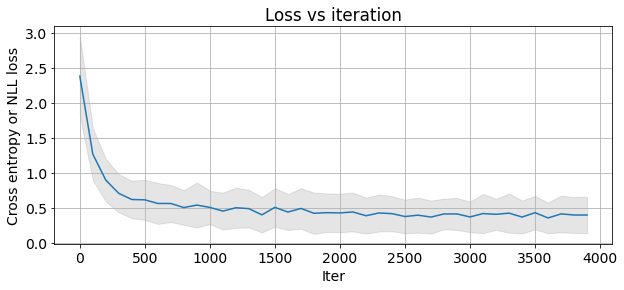

In [267]:
print("We expect this to be large as we overfitted on a small batch.")
train_loop(
    Xs=Xtr_sml,
    Ys=Ytr_sml,
    mdl=wn_mdl,
    lr=0.1,
    num_iter=2000,
    losses=losses,
    batch_sz=10,
    plot_losses=True,
);

#### Sequential

In [270]:
seq_mdl = build_bengio_model(num_hidden=2, lin_wt_gain=5 / 3, batchnorm=True)
Xtr_sml, Ytr_sml = Xtr[:50], Ytr[:50]
losses = []
seq_mdl


Number of sequential model params: 12,659


Sequential(
	Embedding(num_embed=27, embed_dim=10, flatten=False)	out=None
	FlattenConsecutive(n=8)	out=None
	Linear(fanin=80, fanout=68, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.18633899812498247)	out=None
	BatchNorm1D(size=68, ndim=2, momentum=0.01, eps=1e-05)	out=None
	Tanh()	out=None
	Linear(fanin=68, fanout=68, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.20211302086361083)	out=None
	BatchNorm1D(size=68, ndim=2, momentum=0.01, eps=1e-05)	out=None
	Tanh()	out=None
	Linear(fanin=68, fanout=27, bias=True, wt_gain=1.0, init_wt_scale=0.12126781251816648)	out=None
	BatchNorm1D(size=27, ndim=2, momentum=0.01, eps=1e-05)	out=None
)

  0%|          | 0/2000 [00:00<?, ?it/s]

We expect this to be large as we overfitted on a small batch.
Train loss=5.3849
Validation loss=5.4268


Sequential(
	Embedding(num_embed=27, embed_dim=10, flatten=False)	out=(22814, 8, 10)
	FlattenConsecutive(n=8)	out=(22814, 80)
	Linear(fanin=80, fanout=68, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.18633899812498247)	out=(22814, 68)
	BatchNorm1D(size=68, ndim=2, momentum=0.01, eps=1e-05)	out=(22814, 68)
	Tanh()	out=(22814, 68)
	Linear(fanin=68, fanout=68, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.20211302086361083)	out=(22814, 68)
	BatchNorm1D(size=68, ndim=2, momentum=0.01, eps=1e-05)	out=(22814, 68)
	Tanh()	out=(22814, 68)
	Linear(fanin=68, fanout=27, bias=True, wt_gain=1.0, init_wt_scale=0.12126781251816648)	out=(22814, 27)
	BatchNorm1D(size=27, ndim=2, momentum=0.01, eps=1e-05)	out=(22814, 27)
)

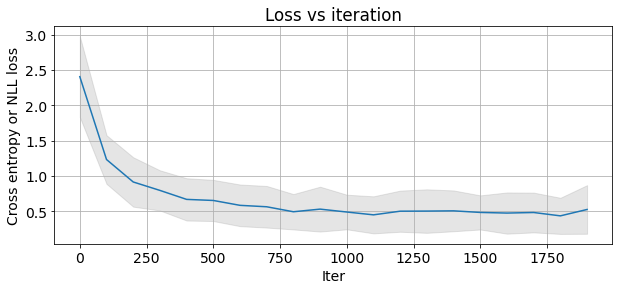

In [246]:
train_loop(
    Xs=Xtr_sml,
    Ys=Ytr_sml,
    mdl=seq_mdl,
    lr=0.1,
    num_iter=2000,
    losses=losses,
    batch_sz=10,
)
_plot_losses(losses[:])
print("We expect this to be large as we overfitted on a small batch.")
split_loss(mdl=seq_mdl, split="train")
split_loss(mdl=seq_mdl, split="val");
seq_mdl

## Train on all data

### Model performance log

#### Model 8 concat
Model: 23k model params; concat 8-50dim char vectors and send through softmax of 51 hidden dim, finally to logit layer.
Settings: 200_000 iterations, batch_sz 32, lr: 0-150_000: 0.1, 150_000-$\infty$: 0.01


Train loss=2.0136\
Validation loss=2.0700

#### Train Model wavenet
**23k parameters**
Settings: 200_000 iterations, batch_sz 32, lr: 0-150_000: 0.1, 150_000-$\infty$: 0.01

Train loss=1.9413\
Validation loss=2.0348

**70k parameters**
Settings: 200_000 iterations, batch_sz 32, lr: 0-150_000: 0.1, 150_000-$\infty$: 0.01

Train loss=1.8422
Validation loss=2.0146

Settings: 100_000 iterations, **batch_sz 256**, lr: 0-150_000: 0.1, 150_000-$\infty$: 0.01\
Overfitted model\
Train loss=1.7747\
Validation loss=2.0348

In [26]:
wn_mdl = build_wavenet(
    embed_dim=128, hidden_dim=100, lin_wt_gain=5 / 3, batchnorm=True
)
losses = []
wn_mdl


Number of model params: 72,437


Sequential(
	Embedding(num_embed=27, embed_dim=128, flatten=False)	out=None
	FlattenConsecutive(n=2)	out=None
	Linear(fanin=256, fanout=100, bias=False, wt_gain=1.6666666666666667, init_wt_scale=0.10416666666666667)	out=None
	BatchNorm1D(size=100, ndim=3, momentum=0.01, eps=1e-05)	out=None
	Tanh()	out=None
	FlattenConsecutive(n=2)	out=None
	Linear(fanin=200, fanout=100, bias=False, wt_gain=1.6666666666666667, init_wt_scale=0.11785113019775792)	out=None
	BatchNorm1D(size=100, ndim=3, momentum=0.01, eps=1e-05)	out=None
	Tanh()	out=None
	FlattenConsecutive(n=2)	out=None
	Linear(fanin=200, fanout=100, bias=False, wt_gain=1.6666666666666667, init_wt_scale=0.11785113019775792)	out=None
	BatchNorm1D(size=100, ndim=2, momentum=0.01, eps=1e-05)	out=None
	Tanh()	out=None
	Linear(fanin=100, fanout=27, bias=True, wt_gain=1.0, init_wt_scale=0.1)	out=None
	BatchNorm1D(size=27, ndim=2, momentum=0.01, eps=1e-05)	out=None
)

In [27]:
train_loop(
    Xs=Xtr,
    Ys=Ytr,
    mdl=wn_mdl,
    lr={(0, 150_000): 0.1, (150_000, np.inf): 0.01},
    num_iter=200_000,
    losses=losses,
    batch_sz=128,
    plot_losses=True,
);

  0%|          | 0/200000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Train loss=1.7747
Validation loss=2.0348


2.034827709197998

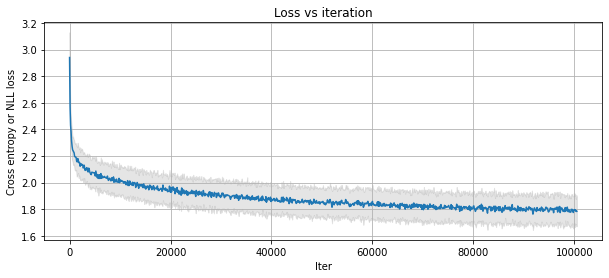

In [31]:
_plot_losses(losses[:])
split_loss(mdl=wn_mdl, split="train")
split_loss(mdl=wn_mdl, split="val")

#### Train Sequential model

In [272]:
seq_mdl = build_bengio_model(
    num_hidden=1,
    lin_wt_gain=5 / 3,
    hidden_dim=52,
    embed_dim=50,
    batchnorm=True,
)
losses = []
seq_mdl


Number of sequential model params: 23,791


Sequential(
	Embedding(num_embed=27, embed_dim=50, flatten=False)	out=None
	FlattenConsecutive(n=8)	out=None
	Linear(fanin=400, fanout=52, bias=True, wt_gain=1.6666666666666667, init_wt_scale=0.08333333333333334)	out=None
	BatchNorm1D(size=52, ndim=2, momentum=0.01, eps=1e-05)	out=None
	Tanh()	out=None
	Linear(fanin=52, fanout=27, bias=True, wt_gain=1.0, init_wt_scale=0.1386750490563073)	out=None
	BatchNorm1D(size=27, ndim=2, momentum=0.01, eps=1e-05)	out=None
)

  0%|          | 0/200000 [00:00<?, ?it/s]

Train loss=2.0136
Validation loss=2.0700


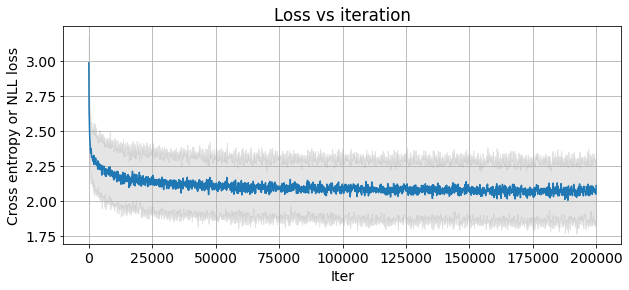

In [257]:
train_loop(
    Xs=Xtr,
    Ys=Ytr,
    mdl=seq_mdl,
    lr={(0, 150_000): 0.1, (150_000, np.inf): 0.01},
    num_iter=200_000,
    losses=losses,
    batch_sz=32,
    plot_losses=True,
)

In [34]:
gen_words = generate_words(mdl=wn_mdl, nwords=10, ctoix=ctoix)
gen_words

['corine',
 'milayza',
 'emmalyna',
 'ilexa',
 'montel',
 'herne',
 'isaac',
 'hajisha',
 'zeton',
 'yefi']

In [35]:
set(gen_words) & set(words)

{'corine', 'isaac', 'montel'}